In [12]:
import numpy as np
from numpy.fft import rfft
import matplotlib.pyplot as plt
import wfdb

from wfdb import Record, MultiRecord
import sounddevice as sd
import pandas as pd
import os

from scipy.fft import fft, fftfreq
from typing import Any
from scipy.signal import find_peaks
from scipy.stats import skew

In [2]:
plt.style.use("dark_background")

In [3]:
# Vstupní data: https://physionet.org/content/voiced/1.0.0/

In [25]:
def record_info(record: Record) -> None:
    info = [
        ["Název souboru", record.record_name],
        ["Vzorkovací frekvence (Hz)", record.fs],
        ["Délka signálu (vzorky)", record.sig_len],
        ["Počet kanálů", record.n_sig],
        ["Názvy kanálů", ", ".join(record.sig_name)],
        ["Jednotky pro každý kanál", ", ".join(record.units)],
    ]
    info_df = pd.DataFrame(info, columns=["Informace", "Hodnota"])
    display(info_df)


def get_file_path(file: str) -> str:
    return f"data/{file}"


def load_record(file: str) -> Record:
    return wfdb.rdrecord(get_file_path(file))


def load_signal(file: str, should_remove_silence=True) -> np.ndarray:
    record: Record = load_record(file)
    signal: np.ndarray = record.p_signal[:, 0]
    if should_remove_silence:
        signal = remove_silence(signal)
    return signal


def remove_silence(signal: np.ndarray, threshold: float = 0.01) -> np.ndarray:
    indices = np.where(np.abs(signal) > threshold)[0]
    if len(indices) < 2:
        return signal
    return signal[indices[0] : indices[-1] + 1]


def plot_signal(title: str, signal: np.ndarray, fs: int = 8000) -> None:
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(18, 5))
    plt.title(title)
    plt.plot(time, signal, label=title, color="magenta")
    plt.xlabel("Čas [s]")
    plt.ylabel("Amplituda [NU]")
    plt.grid(which="both", linestyle="--", alpha=0.2)
    plt.show()


def plot_frequency_spectrum(title: str, signal: np.ndarray, fs: int = 8000) -> None:
    n = len(signal)
    windowed = signal * np.hamming(n)
    spectrum = fft(windowed)
    freq = fftfreq(n, d=1 / fs)
    magnitude = np.abs(spectrum)
    half = n // 2
    plt.figure(figsize=(18, 5))
    plt.title(title)
    plt.plot(freq[:half], magnitude[:half], color="magenta")
    plt.xlabel("Frekvence [Hz]")
    plt.ylabel("Velikost frekvenční složky")
    plt.grid(which="both", linestyle="--", alpha=0.2)
    plt.show()


def get_possible_diagnoses() -> set[str]:
    results = set()
    folder = "data"
    for file in os.listdir(folder):
        if file.endswith(".hea"):
            file_no_extension = file[:-4]
            file_path = os.path.join(folder, file_no_extension)
            header = wfdb.rdheader(file_path)
            comment: str = header.comments[0]
            diagnoses = comment.split("<diagnoses>:")[1].split("<")[0].strip()
            results.add(diagnoses)
    return results


def extract_hea_data(header: Record | MultiRecord) -> dict[str, Any]:
    comment: str = header.comments[0]
    diagnoses = comment.split("<diagnoses>:")[1].split("<")[0].strip()
    file_no_extension = header.file_name[0][:-4]
    return {
        "File": file_no_extension,
        "IsHealthy_Correct": diagnoses == "healthy",
    }


def extract_all_hea_data() -> pd.DataFrame:
    results = []
    folder = "data"
    for file in os.listdir(folder):
        if file.endswith(".hea"):
            file_no_extension = file[:-4]
            file_path = os.path.join(folder, file_no_extension)
            header = wfdb.rdheader(file_path)
            results.append(extract_hea_data(header))
    return pd.DataFrame(results)


def extract_signal_data(file: str, signal: np.ndarray) -> dict[str, Any]:
    return {
        "File": file,
        "IsHealthy_Detected": is_voice_healthy(signal),
    }


def extract_all_signal_data() -> pd.DataFrame:
    results = []
    folder = "data"
    for file in os.listdir(folder):
        if file.endswith(".dat"):
            file_no_extension = file[:-4]
            signal = load_signal(file_no_extension)
            results.append(extract_signal_data(file_no_extension, signal))
    return pd.DataFrame(results)


def evaluate_single_file(file: str) -> pd.DataFrame:
    header = wfdb.rdheader(f"data/{file}")
    signal: np.ndarray = load_signal(file)
    detected = pd.DataFrame([extract_signal_data(file, signal)])
    actual = pd.DataFrame([extract_hea_data(header)])
    merged = pd.merge(detected, actual, on="File")
    merged["IsCorrect"] = merged["IsHealthy_Detected"] == merged["IsHealthy_Correct"]
    return merged


def evaluate_dataset() -> None:
    folder = "data"
    results = []
    for file in os.listdir(folder):
        if file.endswith(".hea"):
            file_no_ext = file[:-4]
            results.append(evaluate_single_file(file_no_ext))

    full_df = pd.concat(results, ignore_index=True)
    correct_count = full_df["IsCorrect"].sum()
    incorrect_count = len(full_df) - correct_count
    total = len(full_df)
    accuracy_percent = (correct_count / total) * 100

    summary_df = pd.DataFrame(
        {
            "Metrika": ["Správně", "Špatně", "Celkem", "Úspěšnost (%)"],
            "Hodnota": [correct_count, incorrect_count, total, accuracy_percent],
        }
    )
    print("\nSouhrnná statistika:")
    display(summary_df)


def spectral_entropy(magnitude: np.ndarray) -> float:
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    # https://cs.wikipedia.org/wiki/Informa%C4%8Dn%C3%AD_entropie
    p = magnitude / np.sum(magnitude)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))


def compute_fft_features(signal: np.ndarray, sr: int = 8000):
    n = len(signal)
    signal = signal - np.mean(signal)
    windowed = signal * np.hamming(n)
    fft_result = np.fft.fft(windowed)
    magnitude = np.abs(fft_result[: n // 2])
    if not np.any(magnitude):
        return None, None, None, n
    magnitude = magnitude / np.max(magnitude)
    freqs = np.fft.fftfreq(n, 1 / sr)[: n // 2]
    return fft_result, magnitude, freqs, n


def calculate_spectral_features(magnitude: np.ndarray, freqs: np.ndarray):
    centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
    spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * magnitude) / np.sum(magnitude))
    skewness = skew(magnitude)
    entropy = spectral_entropy(magnitude)
    return centroid, spread, skewness, entropy


def calculate_cepstral_features(fft_result: np.ndarray, n: int):
    log_magnitude = np.log(np.abs(fft_result) + 1e-10)
    cepstrum = np.fft.ifft(log_magnitude).real
    ceps_start = 20
    cepts_end = n // 3
    if cepts_end <= ceps_start:
        return None, None
    cepts_segment = cepstrum[ceps_start:cepts_end]
    peak_idx_local = np.argmax(np.abs(cepts_segment))
    peak_idx_global = peak_idx_local + ceps_start
    cep_peak = cepstrum[peak_idx_global]
    cep_mean = np.mean(np.abs(cepstrum[1:14]))
    return cep_peak, cep_mean


def analyze_peak_features(magnitude: np.ndarray, freqs: np.ndarray):
    peaks, _ = find_peaks(magnitude, height=0.1, prominence=0.05)
    if len(peaks) > 1:
        peak_freqs = freqs[peaks]
        freq_diffs = np.diff(peak_freqs)
        if len(freq_diffs) == 0 or np.mean(freq_diffs) == 0:
            harmonic_regularity = float("inf")
        else:
            harmonic_regularity = np.std(freq_diffs) / np.mean(freq_diffs)
        fundamental_freq_variability = (
            np.std(freq_diffs) if len(freq_diffs) > 1 else float("inf")
        )
        f0 = np.mean(freq_diffs) if len(freq_diffs) > 0 else 0
    else:
        harmonic_regularity = float("inf")
        fundamental_freq_variability = float("inf")
        f0 = 0
    return f0, harmonic_regularity, fundamental_freq_variability


def is_voice_healthy(signal: np.ndarray) -> bool:
    """ """
    # Prahové hodnoty a požadovaný počet splněných kritérií
    CENTROID_THRESHOLD = 1300.0
    SPREAD_THRESHOLD = 700.0
    SKEWNESS_THRESHOLD = 1.4
    CEPSTRAL_PEAK_THRESHOLD = 4.5
    ENTROPY_THRESHOLD = 3.9
    F0_MIN = 70.0
    F0_MAX = 300.0
    REGULARITY_THRESHOLD = 0.4
    FREQ_VARIABILITY_THRESHOLD = 8.0
    CEPS_MEAN_THRESHOLD = 0.55
    REQUIRED_CONDITIONS = 5
    sr = 8000

    fft_result, magnitude, freqs, n = compute_fft_features(signal.copy(), sr)
    if magnitude is None:
        return False

    centroid, spread, skewness, entropy = calculate_spectral_features(magnitude, freqs)

    cep_peak, cep_mean = calculate_cepstral_features(fft_result, n)
    if cep_peak is None:
        return False

    f0, harmonic_regularity, fundamental_freq_variability = analyze_peak_features(
        magnitude, freqs
    )

    conditions = [
        centroid < CENTROID_THRESHOLD,
        spread < SPREAD_THRESHOLD,
        abs(skewness) < SKEWNESS_THRESHOLD,
        cep_peak > CEPSTRAL_PEAK_THRESHOLD,
        entropy < ENTROPY_THRESHOLD,
        F0_MIN < f0 < F0_MAX,
        harmonic_regularity < REGULARITY_THRESHOLD,
        fundamental_freq_variability > FREQ_VARIABILITY_THRESHOLD,
        cep_mean < CEPS_MEAN_THRESHOLD,
    ]

    return sum(conditions) >= REQUIRED_CONDITIONS

In [5]:
# healthy (voice002)
# hyperkineti dysphonia = hyperkinetic dysphonia (voice001)
# hypokinetic dysphonia (voice004)
# reflux laryngitis (voice008)
get_possible_diagnoses()

{'healthy',
 'hyperkineti dysphonia',
 'hyperkinetic dysphonia',
 'hypokinetic dysphonia',
 'reflux laryngitis'}

In [6]:
record_info(load_record("voice002"))

,Informace,Hodnota
0,Název souboru,voice002
1,Vzorkovací frekvence (Hz),8000
2,Délka signálu (vzorky),38080
3,Počet kanálů,1
4,Názvy kanálů,voice
5,Jednotky pro každý kanál,NU


In [7]:
# NU = Normalized Unit
# Zde zjišťuji, na jaké rozmezí byla amplituda hlasu normalizována.

folder = "data"
global_max = -np.inf
global_min = np.inf

for file in os.listdir(folder):
    if file.endswith(".dat"):
        file_path = os.path.join(folder, file[:-4])
        record: Record = wfdb.rdrecord(file_path)
        signal = record.p_signal[:, 0]
        file_max = np.max(signal)
        file_min = np.min(signal)
        if file_max > global_max:
            global_max = file_max
        if file_min < global_min:
            global_min = file_min

# Dedukce je taková, že rozmezí je na intervalu od -1 do 1.
print("Celková maximální hodnota signálů:", global_max)
print("Celková minimální hodnota signálů:", global_min)

Celková maximální hodnota signálů: 0.999969482654695
Celková minimální hodnota signálů: -0.9999999997671729


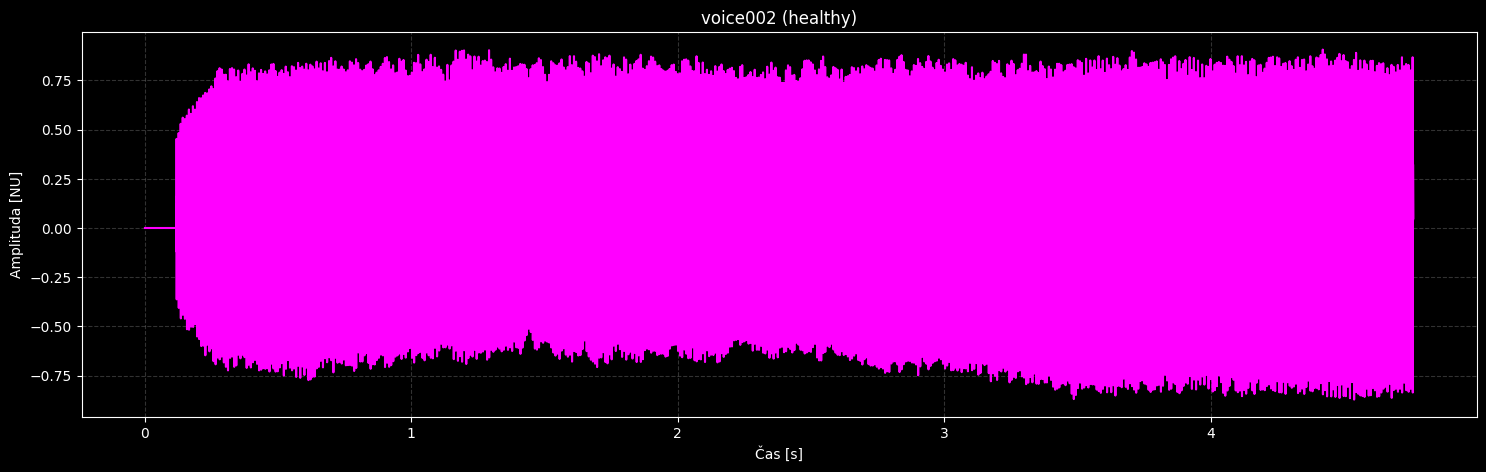

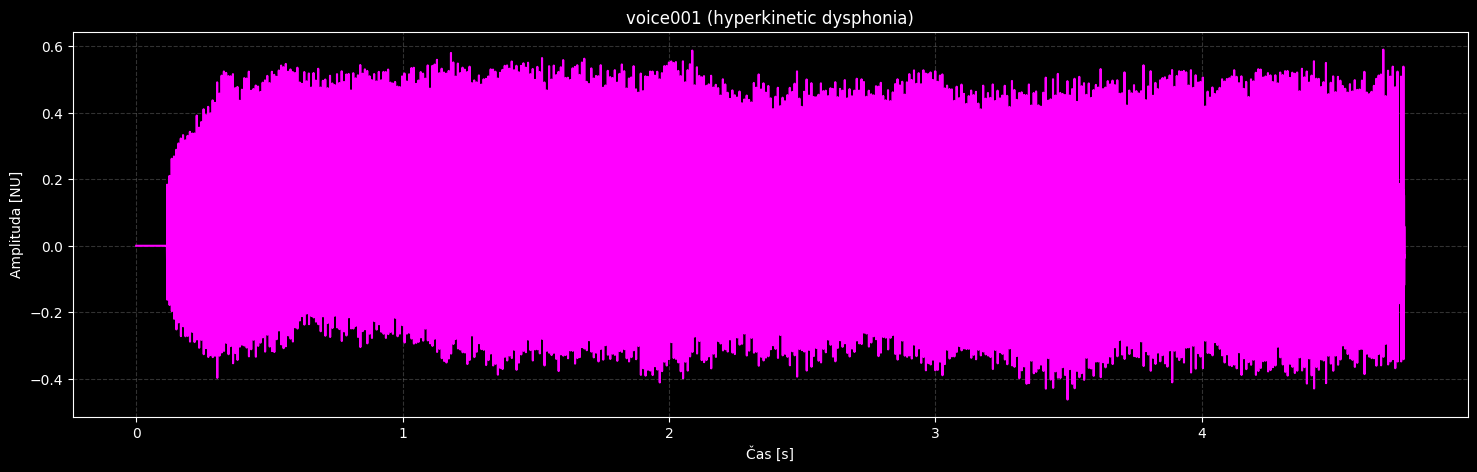

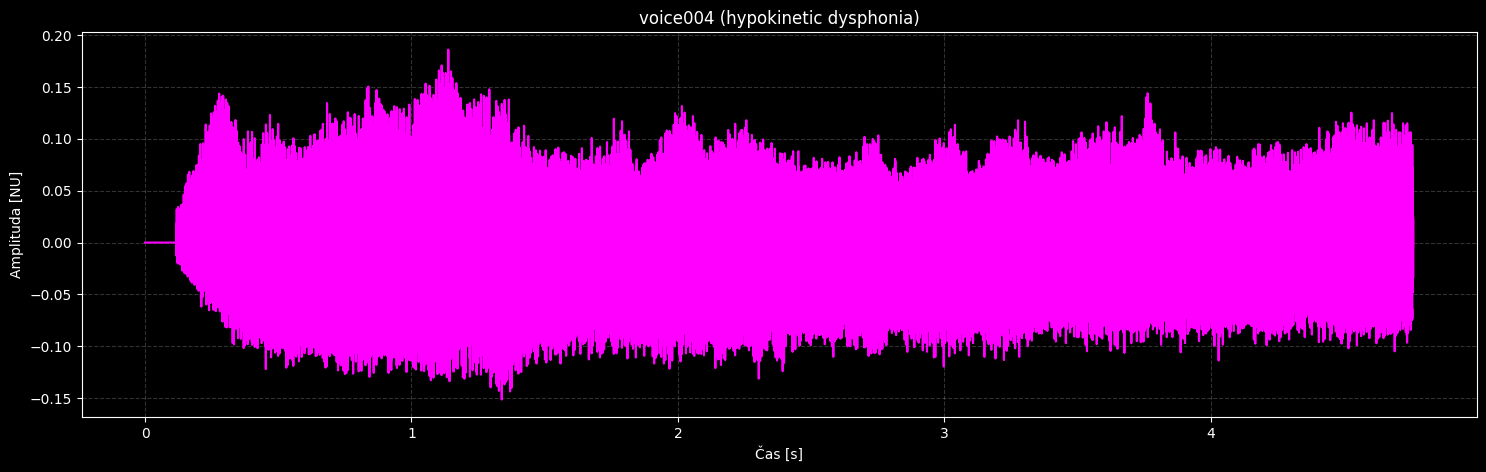

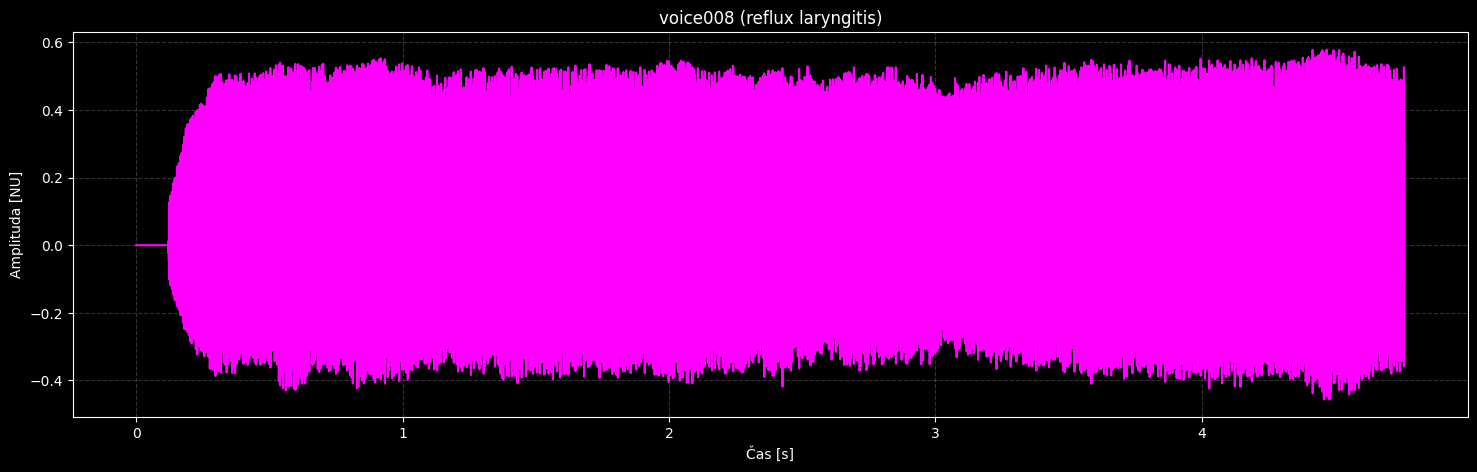

In [8]:
file = "voice002"
signal: np.ndarray = load_signal(file, should_remove_silence=False)
plot_signal(f"{file} (healthy)", signal)

file = "voice001"
signal: np.ndarray = load_signal(file, should_remove_silence=False)
plot_signal(f"{file} (hyperkinetic dysphonia)", signal)

file = "voice004"
signal: np.ndarray = load_signal(file, should_remove_silence=False)
plot_signal(f"{file} (hypokinetic dysphonia)", signal)

file = "voice008"
signal: np.ndarray = load_signal(file, should_remove_silence=False)
plot_signal(f"{file} (reflux laryngitis)", signal)

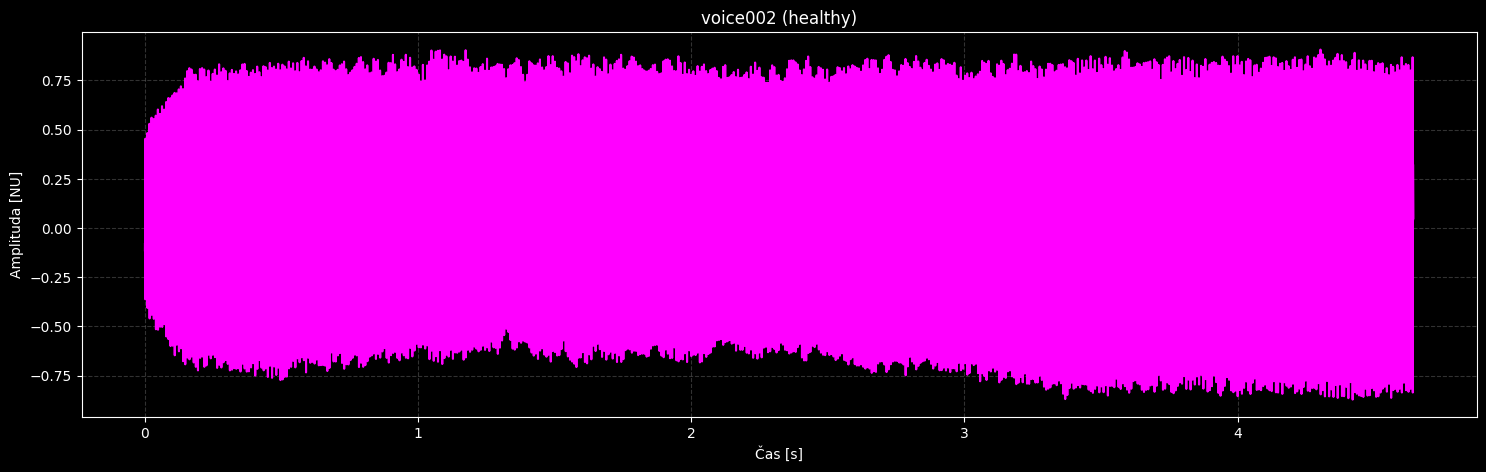

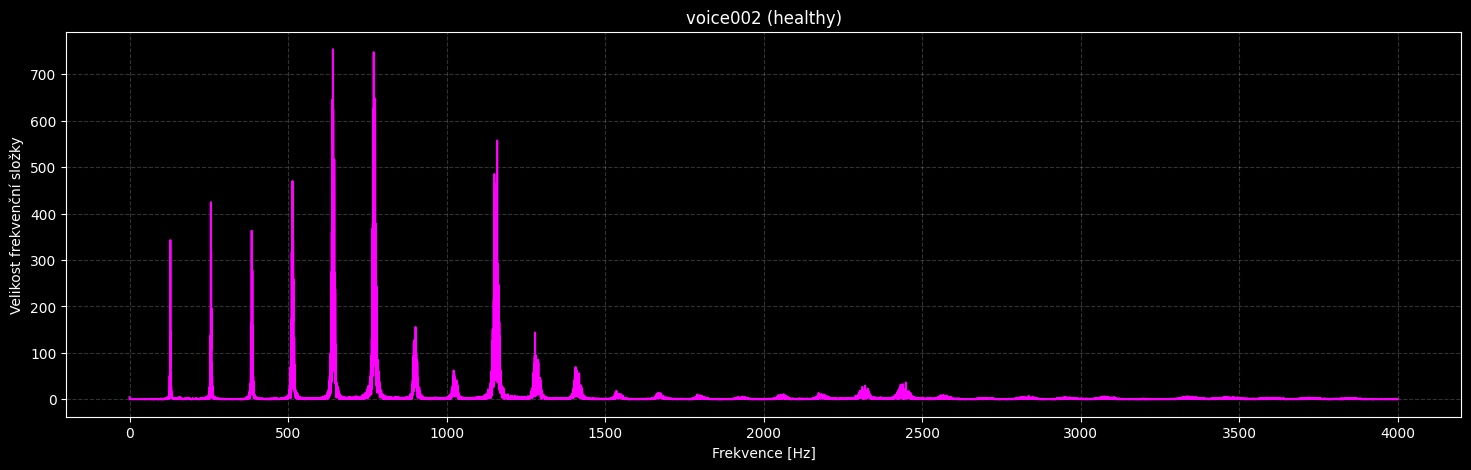

healthy
Průměrná hodnota: -0.00020244118456151023
Maximum: 0.9068603516690876
Minimum: -0.8720397948153135


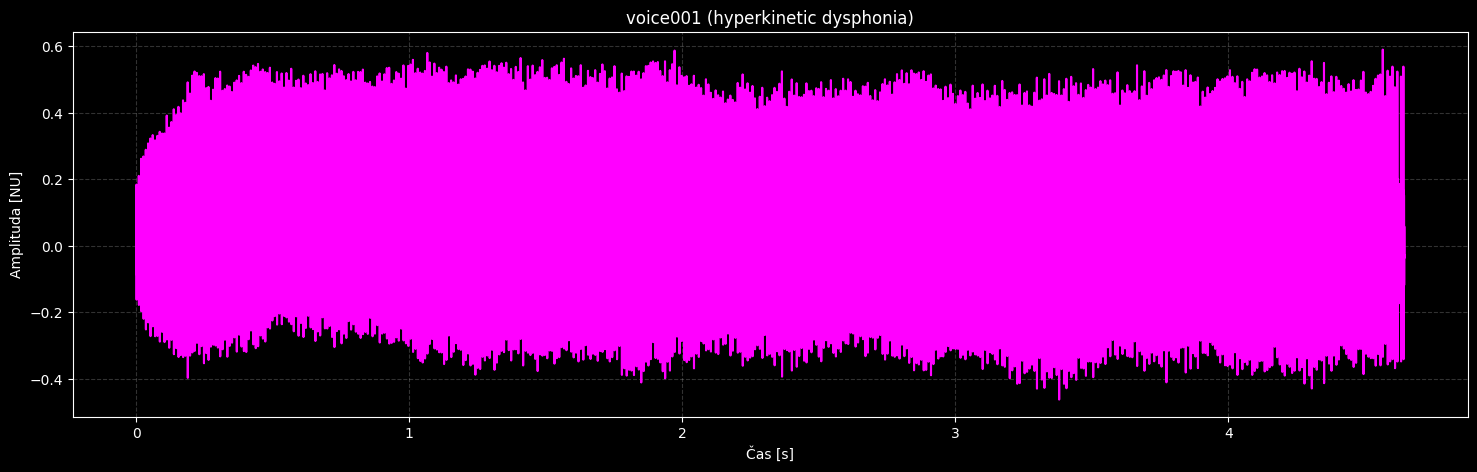

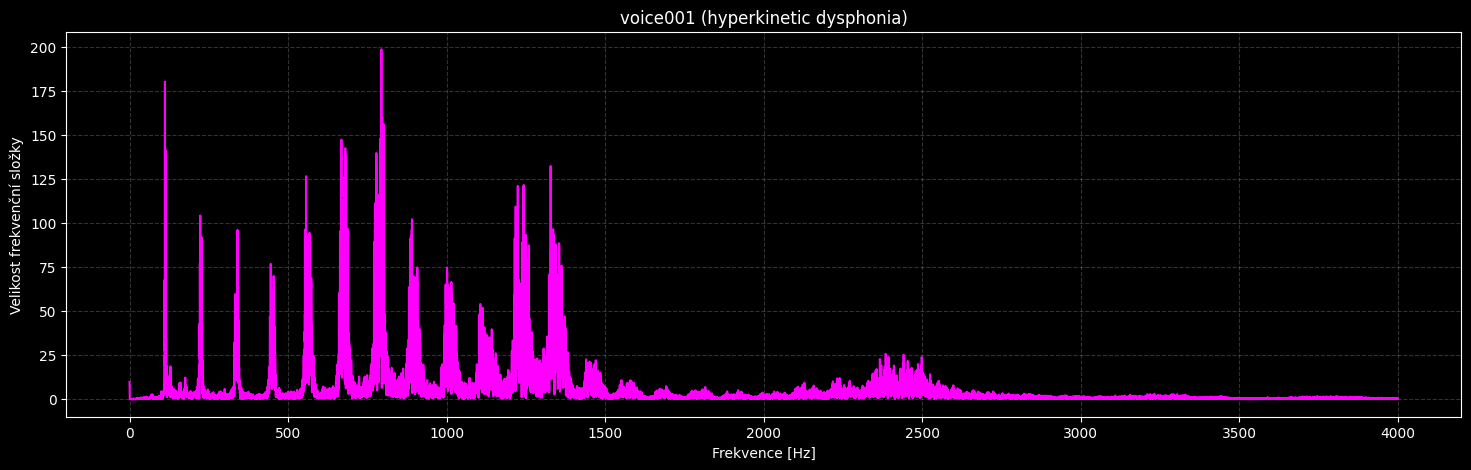

hyperkinetic dysphonia
Průměrná hodnota: -0.0004897300477471891
Maximum: 0.5901184082510088
Minimum: -0.4626464843271041


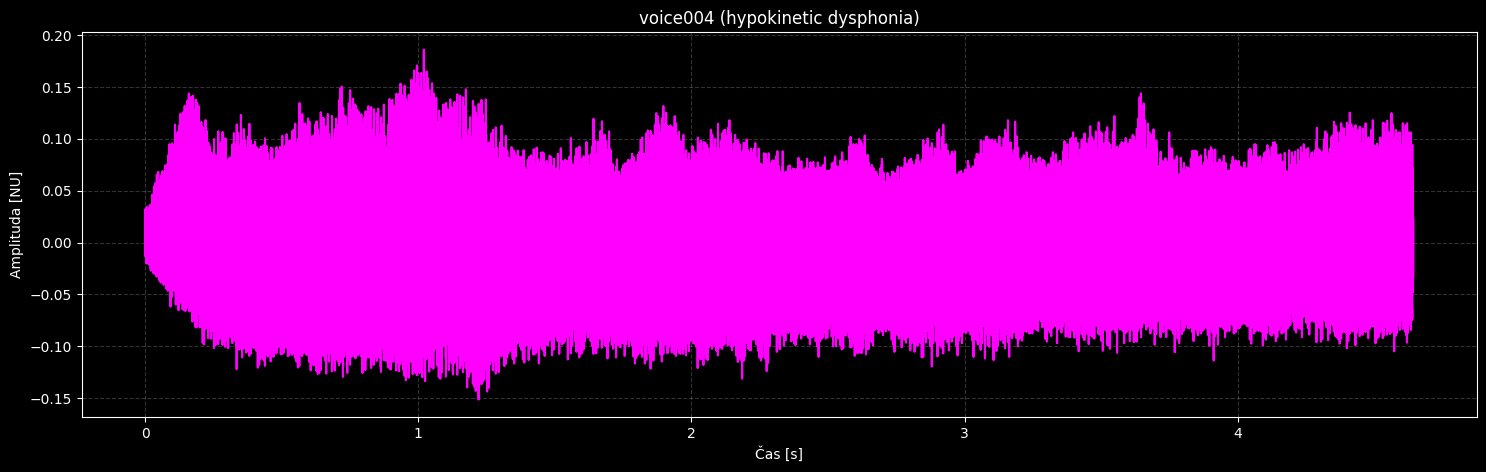

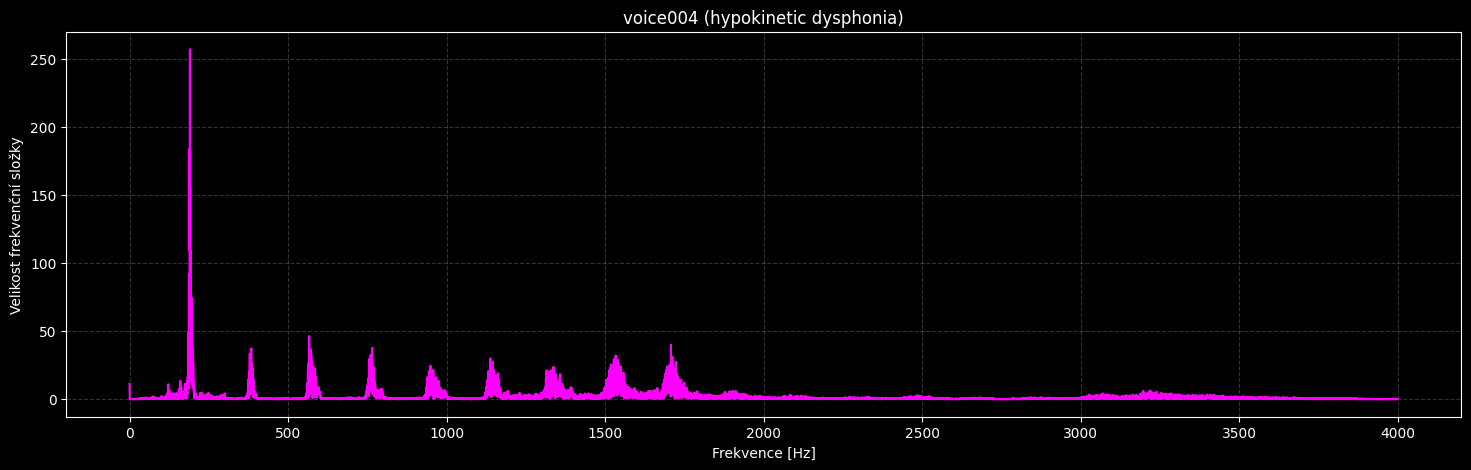

hypokinetic dysphonia
Průměrná hodnota: -0.0005346653058836393
Maximum: 0.18579101558798086
Minimum: -0.1511840820682694


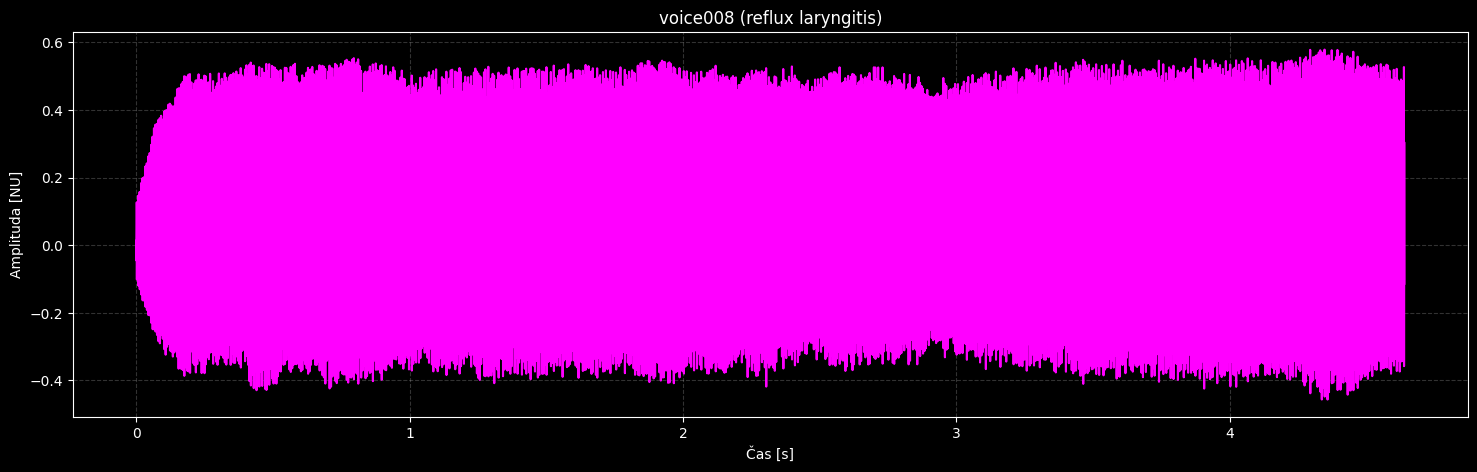

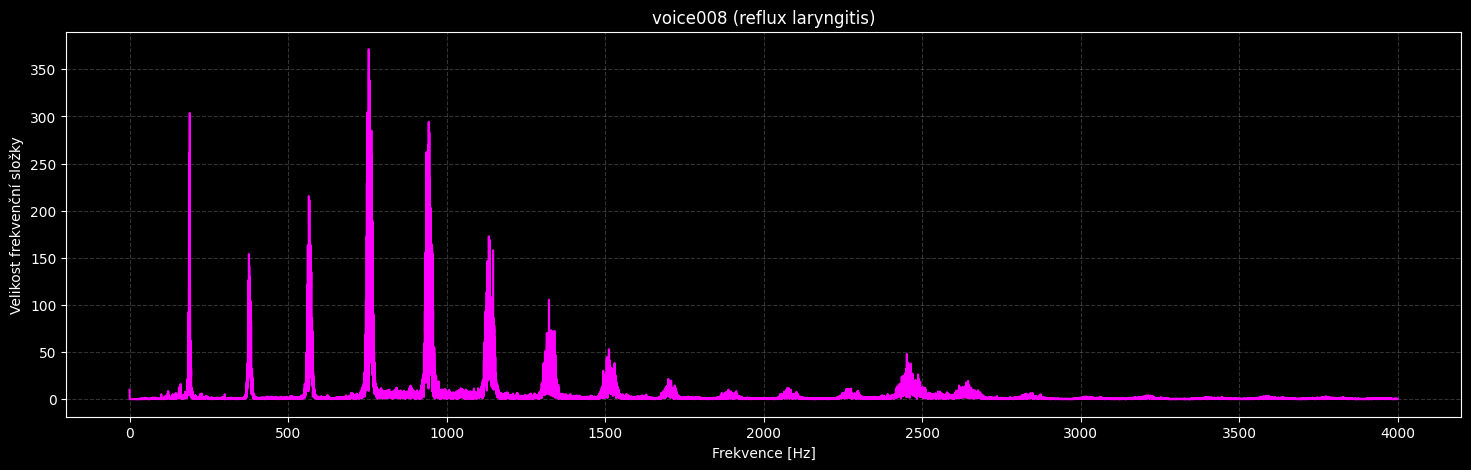

reflux laryngitis
Průměrná hodnota: -0.00048564807088396264
Maximum: 0.5783386231374885
Minimum: -0.4566345213937706


In [9]:
file = "voice002"
signal: np.ndarray = load_signal(file)
# sd.play(signal, samplerate=8000)
# sd.wait()
plot_signal(f"{file} (healthy)", signal)
plot_frequency_spectrum(f"{file} (healthy)", signal)
print("healthy")
print("Průměrná hodnota:", np.mean(signal))
print("Maximum:", np.max(signal))
print("Minimum:", np.min(signal))

file = "voice001"
signal: np.ndarray = load_signal(file)
# sd.play(signal, samplerate=8000)
# sd.wait()
plot_signal(f"{file} (hyperkinetic dysphonia)", signal)
plot_frequency_spectrum(f"{file} (hyperkinetic dysphonia)", signal)
print("hyperkinetic dysphonia")
print("Průměrná hodnota:", np.mean(signal))
print("Maximum:", np.max(signal))
print("Minimum:", np.min(signal))

file = "voice004"
signal: np.ndarray = load_signal(file)
# sd.play(signal, samplerate=8000)
# sd.wait()
plot_signal(f"{file} (hypokinetic dysphonia)", signal)
plot_frequency_spectrum(f"{file} (hypokinetic dysphonia)", signal)
print("hypokinetic dysphonia")
print("Průměrná hodnota:", np.mean(signal))
print("Maximum:", np.max(signal))
print("Minimum:", np.min(signal))

file = "voice008"
signal: np.ndarray = load_signal(file)
# sd.play(signal, samplerate=8000)
# sd.wait()
plot_signal(f"{file} (reflux laryngitis)", signal)
plot_frequency_spectrum(f"{file} (reflux laryngitis)", signal)
print("reflux laryngitis")
print("Průměrná hodnota:", np.mean(signal))
print("Maximum:", np.max(signal))
print("Minimum:", np.min(signal))

In [24]:
evaluate_dataset()


Souhrnná statistika:


,Metrika,Hodnota
0,Správně,151.000000
1,Špatně,57.000000
2,Celkem,208.000000
3,Úspěšnost (%),72.596154
